# inspect single model


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## import human data for fitting
import pandas as pd
hdf = pd.read_csv('../human_data.csv')
humanB_acc,humanI_acc = hdf.loc[:,('blocked mean','interleaved mean')].values.T

In [4]:
## default params
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':210,
    'stickiness_wi':300,
    'stickiness_bt':400, # 100
    'sparsity':1.50,
    'pvar': 0,
    'lrate':1,
    'lratep':1,
    'decay_rate':1,
} 
semargs = {
  'beta2':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_210.000-stickiness_wi_300.000-stickiness_bt_400.000-sparsity_1.500-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000'

### main

In [5]:
ns = 20
L = []
condL = ['blocked','interleaved',
         'early','middle','late'
        ]
exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr,seeds,{data}]


In [6]:
## accuracy
# bads = get_bad_seed(exp_batch_data,max_splits=50)
# goods = np.setdiff1d(np.arange(ns),bads)
batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
mean_acc = batch_acc.mean(1)
test_acc = mean_acc[:,-40:].mean(1) # curr  
test_acc

array([1.        , 0.49714056, 1.        , 0.7961226 , 0.55557349])

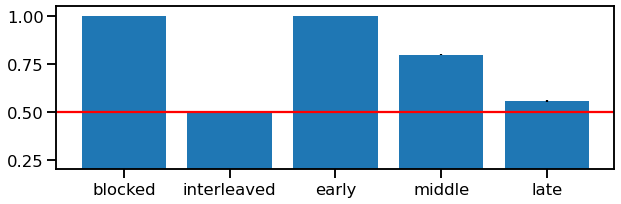

In [7]:
plt.figure(figsize=(10,3))
M = mean_acc[:,-40:].mean(1)
S = mean_acc[:,-40:].std(1)/np.sqrt(ns)
plt.bar(condL,test_acc,yerr=S)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')
plt.savefig('figures/single_model_nb/testacc%s.png'%param_str)

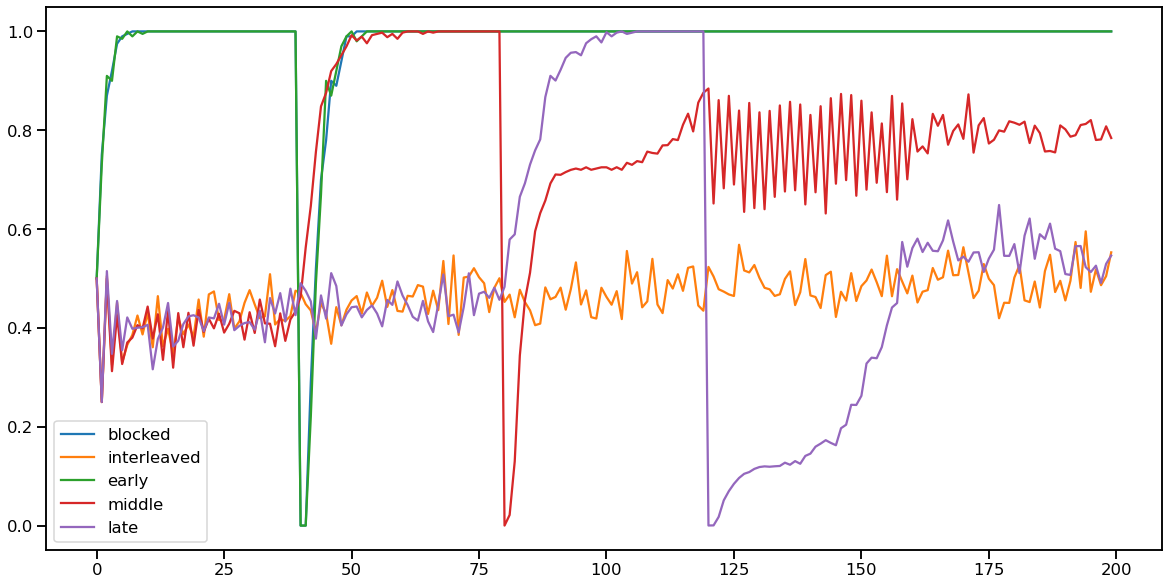

In [8]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.savefig('figures/single_model_nb/acc-by-time-%s.png'%param_str)

# analysis of model state

<BarContainer object of 5 artists>

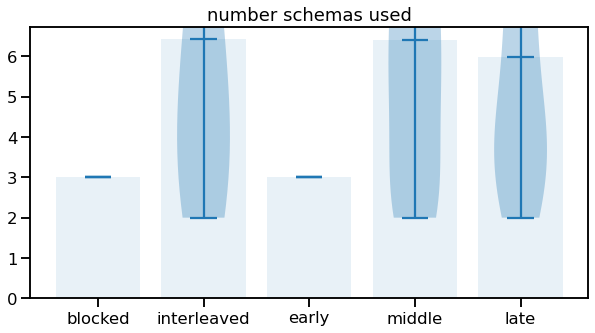

In [9]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(5):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(exp_batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(10,5))
plt.title('number schemas used')
plt.violinplot(nschemas.T,np.arange(5),showmeans=True)
plt.bar(condL,M,zorder=-100,alpha=0.1)


In [10]:
curr_idx = 3
seed_idx = 1
## 
prior = unpack_data(exp_batch_data,
        dtype='prior')[curr_idx][seed_idx]
like = unpack_data(exp_batch_data,
        dtype='like')[curr_idx][seed_idx]
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][seed_idx]
post.shape

(200, 5, 7)

In [11]:
curr = 3
seed = 1
zt = exp_batch_data[curr][seed]['zt']
st = exp_batch_data[curr][seed]['exp']

prior = unpack_data(exp_batch_data,
        dtype='prior')[curr][seed] # trial,tstep,sch
like = unpack_data(exp_batch_data,
        dtype='like')[curr][seed]
post = unpack_data(exp_batch_data,
        dtype='post')[curr][seed]


for i in range(200):
  print(i,zt[i],st[i],
       post[i,:,1],
       post[i,:,2]
       )

0 [ 0. -1.  0.  0. -1.] [0 1 4 6 8] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
1 [ 0. -1.  0.  0. -1.] [0 2 3 6 7] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
2 [ 0. -1.  0.  0. -1.] [0 1 3 5 7] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
3 [ 0. -1.  0.  0. -1.] [0 2 3 6 7] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
4 [ 0. -1.  0.  0. -1.] [0 1 3 5 7] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
5 [ 0. -1.  0.  1. -1.] [0 2 4 5 8] [105.  -1. 105. 105.  -1.] [-1. -1. -1. -1. -1.]
6 [ 1. -1.  1.  1. -1.] [0 1 4 6 8] [200.5  -1.  151.  151.5  -1. ] [105.  -1. 105. 105.  -1.]
7 [ 1. -1.  1.  1. -1.] [0 2 3 6 7] [151.5   -1.   152.5  114.75  -1.  ] [105.  -1. 105. 105.  -1.]
8 [ 1. -1.  1.  1. -1.] [0 1 4 6 8] [203.5  -1.  192.5 154.5  -1. ] [105.  -1. 105. 105.  -1.]
9 [ 1. -1.  1.  1. -1.] [0 2 3 6 7] [170.83333333  -1.         194.375      130.          -1.        ] [105.  -1. 105. 105.  -1.]
10 [ 1. -1.  1.  1. -1.] [0 1 4 6 8] [206.5  -1.  219.8 157.5  -1. ] [

In [12]:
tstep = 0
sch = 1
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][s]
post[:,tstep,sch]


NameError: name 's' is not defined

In [ ]:
def get_bad_seed(exp_batch_data,max_splits=10):
  bad_seed_L = []
  for curr_idx in range(5):
    for seed_idx in range(ns):
      max_sch = np.max(exp_batch_data[curr_idx][seed_idx]['zt'])
      if max_sch>max_splits:
        bad_seed_L.append(seed_idx)
  return list(set(bad_seed_L))
get_bad_seed(exp_batch_data,max_splits=10)